In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tqdm import tqdm
from __future__ import division
import numpy as np
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import (StationaryKernelMixin,NormalizedKernelMixin,Kernel,Hyperparameter,squareform,pdist,cdist)
import scipy.spatial.distance as distance
import joblib
import matplotlib.pyplot as plt
import os

In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Data\Updateddata.txt",names = columns)
datatab
x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']

# First Mass
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))

# Second Mass
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))

# Third Mass
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))

# Fourth Mass
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))

X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

In [3]:
indices = np.arange(X.shape[0])
X_trainval, X_test, D_trainval, D_test, E_trainval, E_test, indices_trainval, indices_test = train_test_split(X, D,E,indices, test_size=0.1, random_state=42)

Processing kernels: 100%|██████████| 8/8 [00:00<00:00, 13.05it/s]


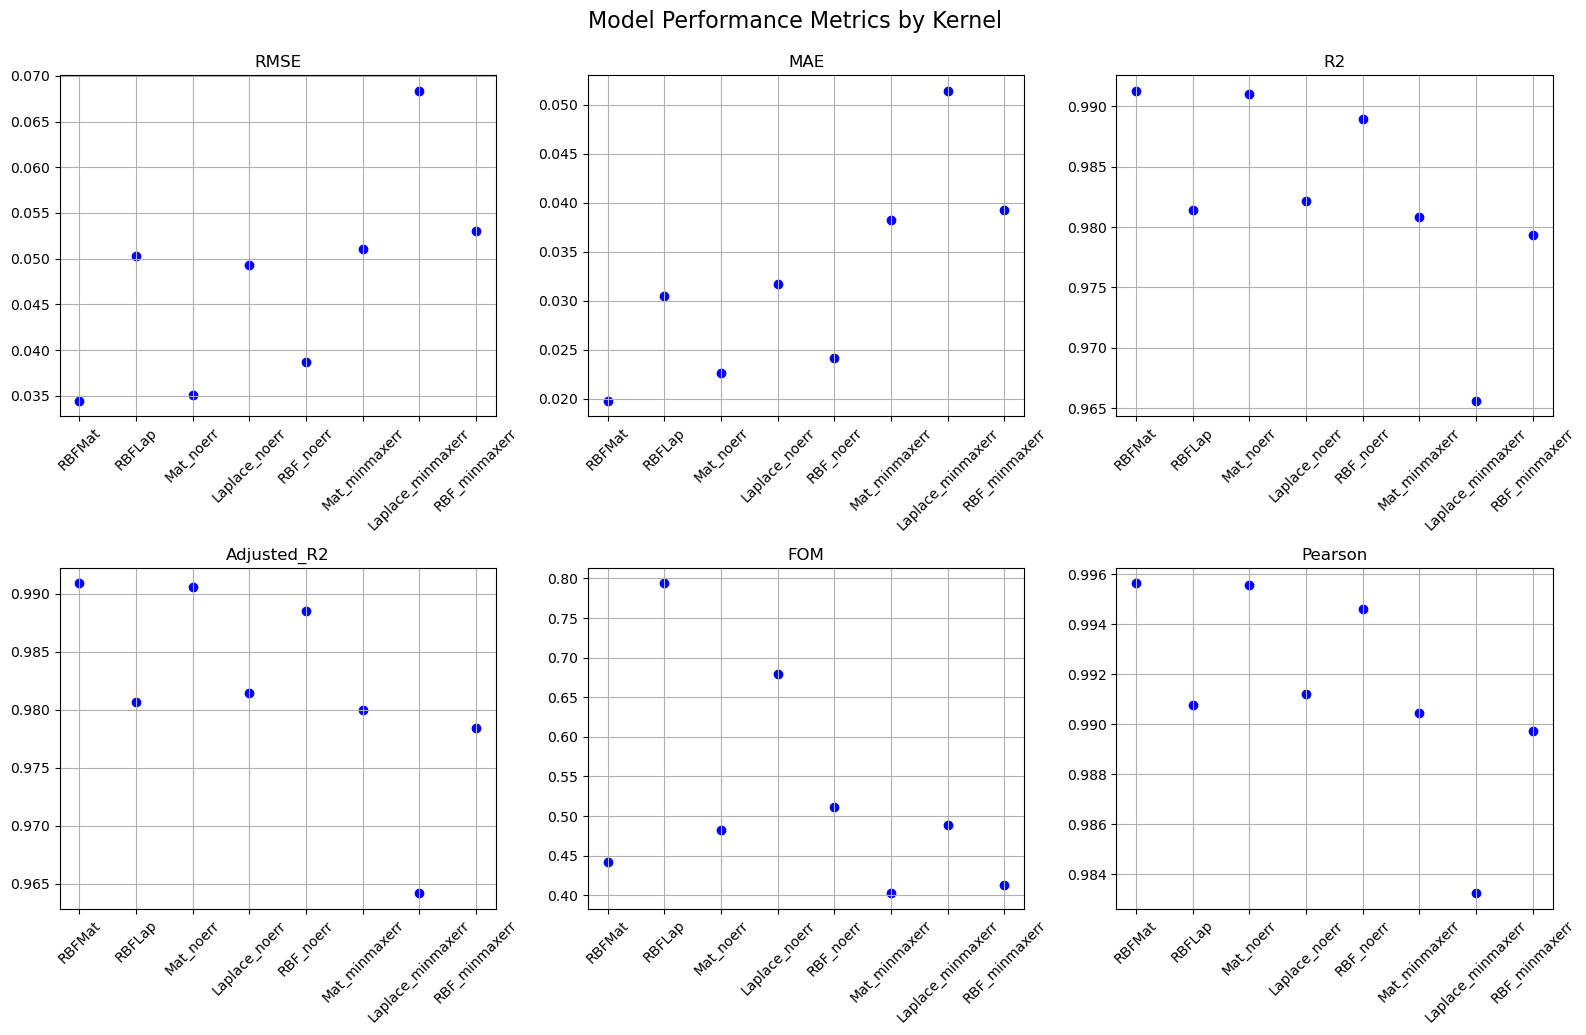

In [ ]:
base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'

# Define only kernel names (used to load from disk)
kernel_names = [
    "RBFMat",
    "RBFLap",
    "Mat_noerr",
    "Laplace_noerr",
    "RBF_noerr",
    "Mat_minmaxerr",
    "Laplace_minmaxerr",
    "RBF_minmaxerr"
]

metrics = {"RMSE": {}, "MAE": {}, "R2": {}, "Adjusted_R2": {}, "FOM": {}, "Pearson":{} }

# Compute metrics
for kernel_name in tqdm(kernel_names, desc="Processing kernels"):
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    mean_pred, std_pred = gpr_loaded.predict(X_test, return_std=True)

    rmse = np.sqrt(mean_squared_error(D_test, mean_pred))
    mae = mean_absolute_error(D_test, mean_pred)
    r2 = r2_score(D_test, mean_pred)
    adj_r2 = 1 - (1 - r2) * (len(D_test) - 1) / (len(D_test) - X_test.shape[1] - 1)
    fom = np.mean(np.abs(D_test - mean_pred) / std_pred)
    pearson, _ = pearsonr(D_test.ravel(), mean_pred.ravel())

    # Store metrics
    metrics["RMSE"][kernel_name] = rmse
    metrics["MAE"][kernel_name] = mae
    metrics["R2"][kernel_name] = r2
    metrics["Adjusted_R2"][kernel_name] = adj_r2
    metrics["FOM"][kernel_name] = fom
    metrics["Pearson"][kernel_name] = pearson

# Plot
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs = axs.ravel()

for i, (metric_name, metric_values) in enumerate(metrics.items()):
    axs[i].scatter(list(metric_values.keys()), list(metric_values.values()), color='blue')
    axs[i].set_title(metric_name)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Model Performance Metrics by Kernel", fontsize=16, y=1.03)
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metrics_of_finalists", dpi=72, bbox_inches='tight')
plt.show()



In [6]:
import pandas as pd
import numpy as np

# Step 1: Define kernels and metrics (already loaded in your `metrics` dictionary)
kernel_names = list(metrics['R2'].keys())  # get the kernel names from one of the metric dicts
metric_keys = ['R2', 'RMSE', 'MAE', 'Adjusted_R2', 'FOM', 'Pearson']

# Step 2: Build the initial DataFrame
ranking_df = pd.DataFrame({'Kernel': kernel_names})

# Step 3: Compute metric values and ranks
for metric in metric_keys:
    values = [metrics[metric][k] for k in kernel_names]
    array = np.array(values)

    # Determine rank order
    if metric in ['R2', 'Adjusted_R2', 'Pearson']:
        order = array.argsort()[::-1]  # higher is better
    else:
        order = array.argsort()  # lower is better

    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, len(order) + 1)

    # Add to DataFrame
    ranking_df[metric] = np.round(array, 3)
    ranking_df[f'{metric} Rank'] = ranks

# Step 4: Average rank and final rank
rank_cols = [f'{metric} Rank' for metric in metric_keys]
ranking_df['Average Rank'] = ranking_df[rank_cols].mean(axis=1)

ranking_df = ranking_df.sort_values(by=['Average Rank', 'R2 Rank'], ascending=[True, True]).reset_index(drop=True)
ranking_df['Final Rank'] = np.arange(1, len(ranking_df) + 1)

ranking_dfwork = ranking_df.copy()
print(ranking_dfwork)

# Step 5: Rename columns for LaTeX-like appearance
ranking_df.columns = [
    "Model", "R2", "R", "RMSE", "R",
    "MAE", "R", "adj R2", "R",
    "FOM", "R", "Pearson", "R", "Average Rank","Final R"]
ranking_df = ranking_df.drop("Average Rank", axis=1)
ranking_df["Model"] = ranking_df["Model"].str.replace("_", "")

print("\nFinal Model Ranking Including Combined Kernels:\n")
#print(ranking_df)

#ranking_df.to_csv(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Latex\LatexPlots\CV_plots\final_model_rankings.csv", index=False)

              Kernel     R2  R2 Rank   RMSE  RMSE Rank    MAE  MAE Rank  \
0             RBFMat  0.991        1  0.034          1  0.020         1   
1          Mat_noerr  0.991        2  0.035          2  0.023         2   
2          RBF_noerr  0.989        3  0.039          3  0.024         3   
3      Laplace_noerr  0.982        4  0.049          4  0.032         5   
4      Mat_minmaxerr  0.981        6  0.051          6  0.038         6   
5             RBFLap  0.981        5  0.050          5  0.031         4   
6      RBF_minmaxerr  0.979        7  0.053          7  0.039         7   
7  Laplace_minmaxerr  0.966        8  0.068          8  0.051         8   

   Adjusted_R2  Adjusted_R2 Rank    FOM  FOM Rank  Pearson  Pearson Rank  \
0        0.991                 1  0.442         3    0.996             1   
1        0.991                 2  0.482         4    0.996             2   
2        0.989                 3  0.511         6    0.995             3   
3        0.981      

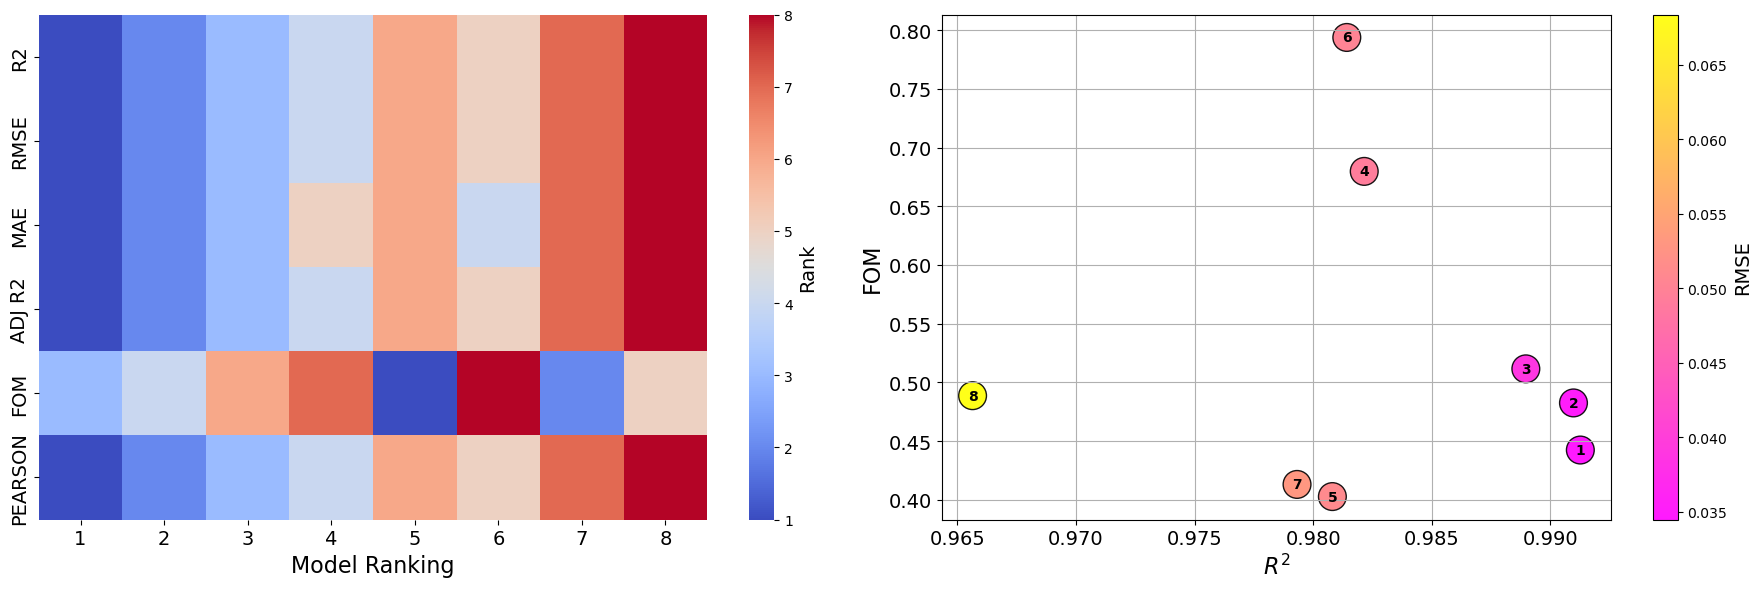

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Prepare Heatmap Data ===
metric_rank_columns = ['R2 Rank', 'RMSE Rank', 'MAE Rank', 'Adjusted_R2 Rank', 'FOM Rank', 'Pearson Rank']
metric_names = ['R2', 'RMSE', 'MAE', 'ADJ R2', 'FOM', 'PEARSON']
rank_data = ranking_dfwork[metric_rank_columns].T
rank_data.index = metric_names  # for clean labels

# === Prepare Scatter Plot Data ===
kernel_names = list(metrics["R2"].keys())
r2_values = [metrics["R2"][name] for name in kernel_names]
fom_values = [metrics["FOM"][name] for name in kernel_names]
rmse_values = [metrics["RMSE"][name] for name in kernel_names]
model_ranks = [ranking_dfwork.loc[ranking_dfwork['Kernel'] == name, 'Final Rank'].values[0] for name in kernel_names]

# === Create Subplots ===
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# === Plot 1: Heatmap ===
sns.heatmap(rank_data, cmap="coolwarm", annot=False, yticklabels=metric_names, ax=axs[0])
axs[0].set_xlabel("Model Ranking", fontsize=16)
axs[0].tick_params(axis='y', labelsize=14)

# Center xticks
num_models = rank_data.shape[1]
axs[0].set_xticks([i + 0.5 for i in range(num_models)])
axs[0].set_xticklabels([str(i + 1) for i in range(num_models)], fontsize=14)

# Colorbar
cbar0 = axs[0].collections[0].colorbar
cbar0.set_label("Rank", fontsize=14)

# === Plot 2: Scatter ===
sc = axs[1].scatter(r2_values, fom_values, c=rmse_values, cmap='spring', s=400, edgecolor='k', alpha=0.9)

# Annotate with model ranks
for i, rank in enumerate(model_ranks):
    axs[1].annotate(str(rank), (r2_values[i], fom_values[i]),
                    fontsize=10, ha='center', va='center', weight='bold')

axs[1].set_xlabel("$R^2$", fontsize=16)
axs[1].set_ylabel("FOM", fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].grid(True)

# Colorbar
cbar1 = fig.colorbar(sc, ax=axs[1])
cbar1.set_label("RMSE", fontsize=14)

# === Finalize ===
plt.tight_layout()
# plt.savefig("your_combined_plot_path.png", dpi=72, bbox_inches='tight')
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metric_of_finalists_comparison",dpi=72, bbox_inches='tight')
plt.show()


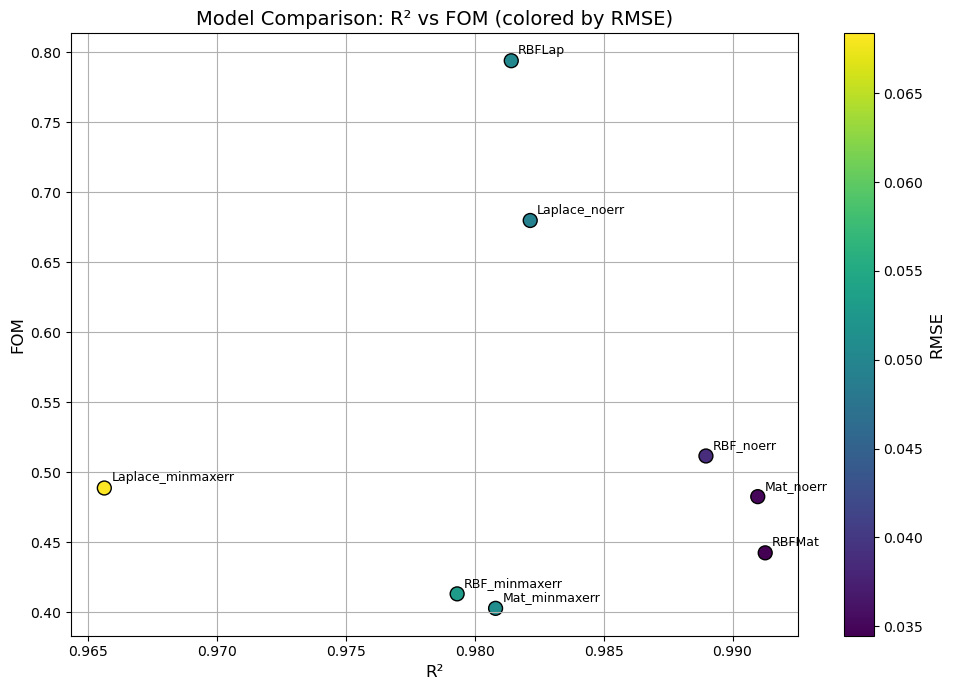

In [59]:
# Extract values
kernel_names = list(metrics["R2"].keys())
r2_values = [metrics["R2"][name] for name in kernel_names]
fom_values = [metrics["FOM"][name] for name in kernel_names]
rmse_values = [metrics["RMSE"][name] for name in kernel_names]

# Scatter plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(r2_values, fom_values, c=rmse_values, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('RMSE', fontsize=12)

# Annotate points
for i, name in enumerate(kernel_names):
    plt.annotate(name, (r2_values[i], fom_values[i]), fontsize=9, xytext=(5, 5), textcoords='offset points')

# Labels and title
plt.xlabel("R²", fontsize=12)
plt.ylabel("FOM", fontsize=12)
plt.title("Model Comparison: R² vs FOM (colored by RMSE)", fontsize=14)
plt.grid(True)
plt.tight_layout()
##plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\metric_of_finalists_comparison",dpi=72, bbox_inches='tight')
plt.show()

Plotting each kernel: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


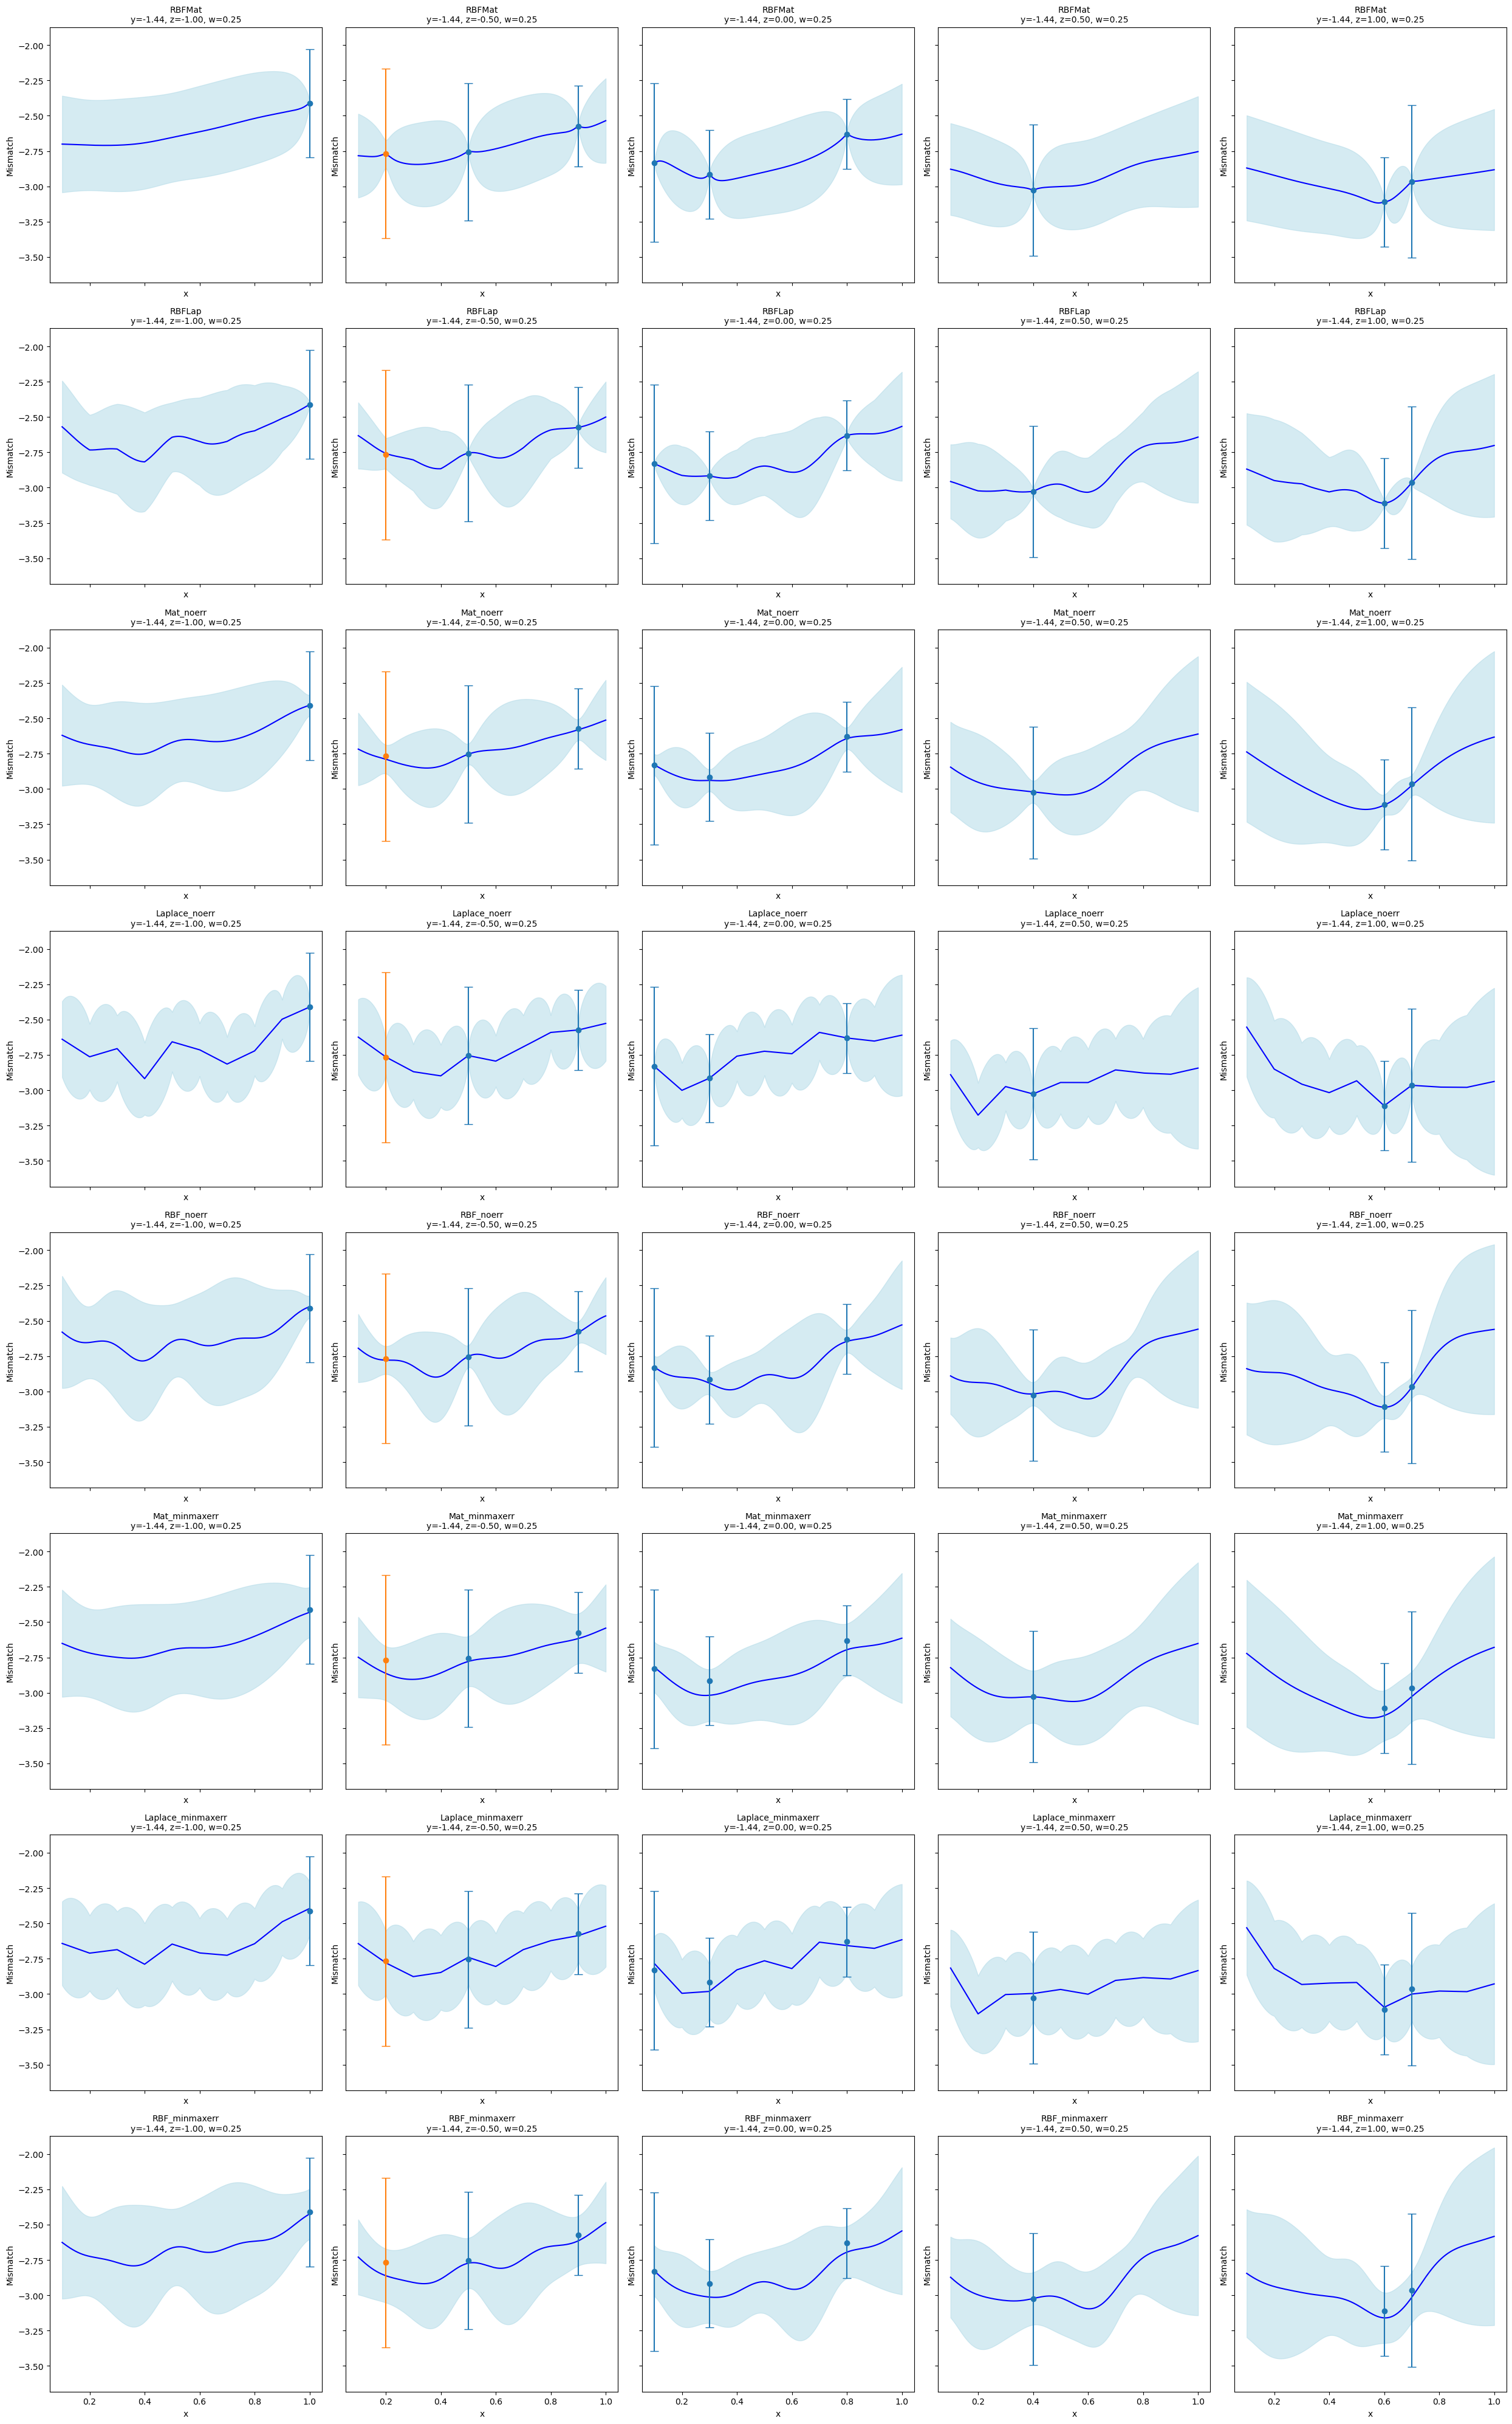

In [ ]:
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]


x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]


xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
ypoints = np.linspace(-np.pi/2, np.pi/2, 25)
wpoints = np.linspace(0.25, 1, 4)

i = 1  # index for ypoint
j = 0  # index for wpoint
ypoint = ypoints[i]
wpoint = wpoints[j]

# # Model names only
# kernel_names = [
#     "RBFMat", "RBFLap", "Mat_noerr", "Laplace_noerr",
#     "RBF_noerr", "Mat_minmaxerr", "Laplace_minmaxerr", "RBF_minmaxerr"
# ]

# Plotting
num_kernels = len(kernel_names)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

for row, kernel_name in enumerate(tqdm(kernel_names, desc="Plotting each kernel")):
    # Load model
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]
        
        # Create prediction inputs (x varies, others fixed)
        Xpred = np.column_stack((
            xdomain,
            np.full_like(xdomain, ypoint),
            np.full_like(xdomain, zpoint),
            np.full_like(xdomain, wpoint)
        ))

        # Predict
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        # Plot mean and confidence interval
        ax.plot(xdomain, pred_mean, color='blue')
        ax.fill_between(xdomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Filter training/test points near y and z
        indtrain = np.isclose(y1train, ypoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest = np.isclose(y1test, ypoint, atol=0.05) & np.isclose(z1test, zpoint, atol=0.05)

        # Overlay points
        ax.errorbar(x1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain], fmt='o', color='#1f77b4', capsize=5)
        ax.errorbar(x1test[indtest],  D1_test[indtest],   yerr=E1_test[indtest],  fmt='o', color='#ff7f0e', capsize=5)

        # Label
        ax.set_title(f"{kernel_name}\ny={ypoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("x")
        ax.set_ylabel("Mismatch")

plt.tight_layout()
# plt.savefig("your_path_here.png", dpi=72, bbox_inches='tight')
plt.show()


Processing kernels: 100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


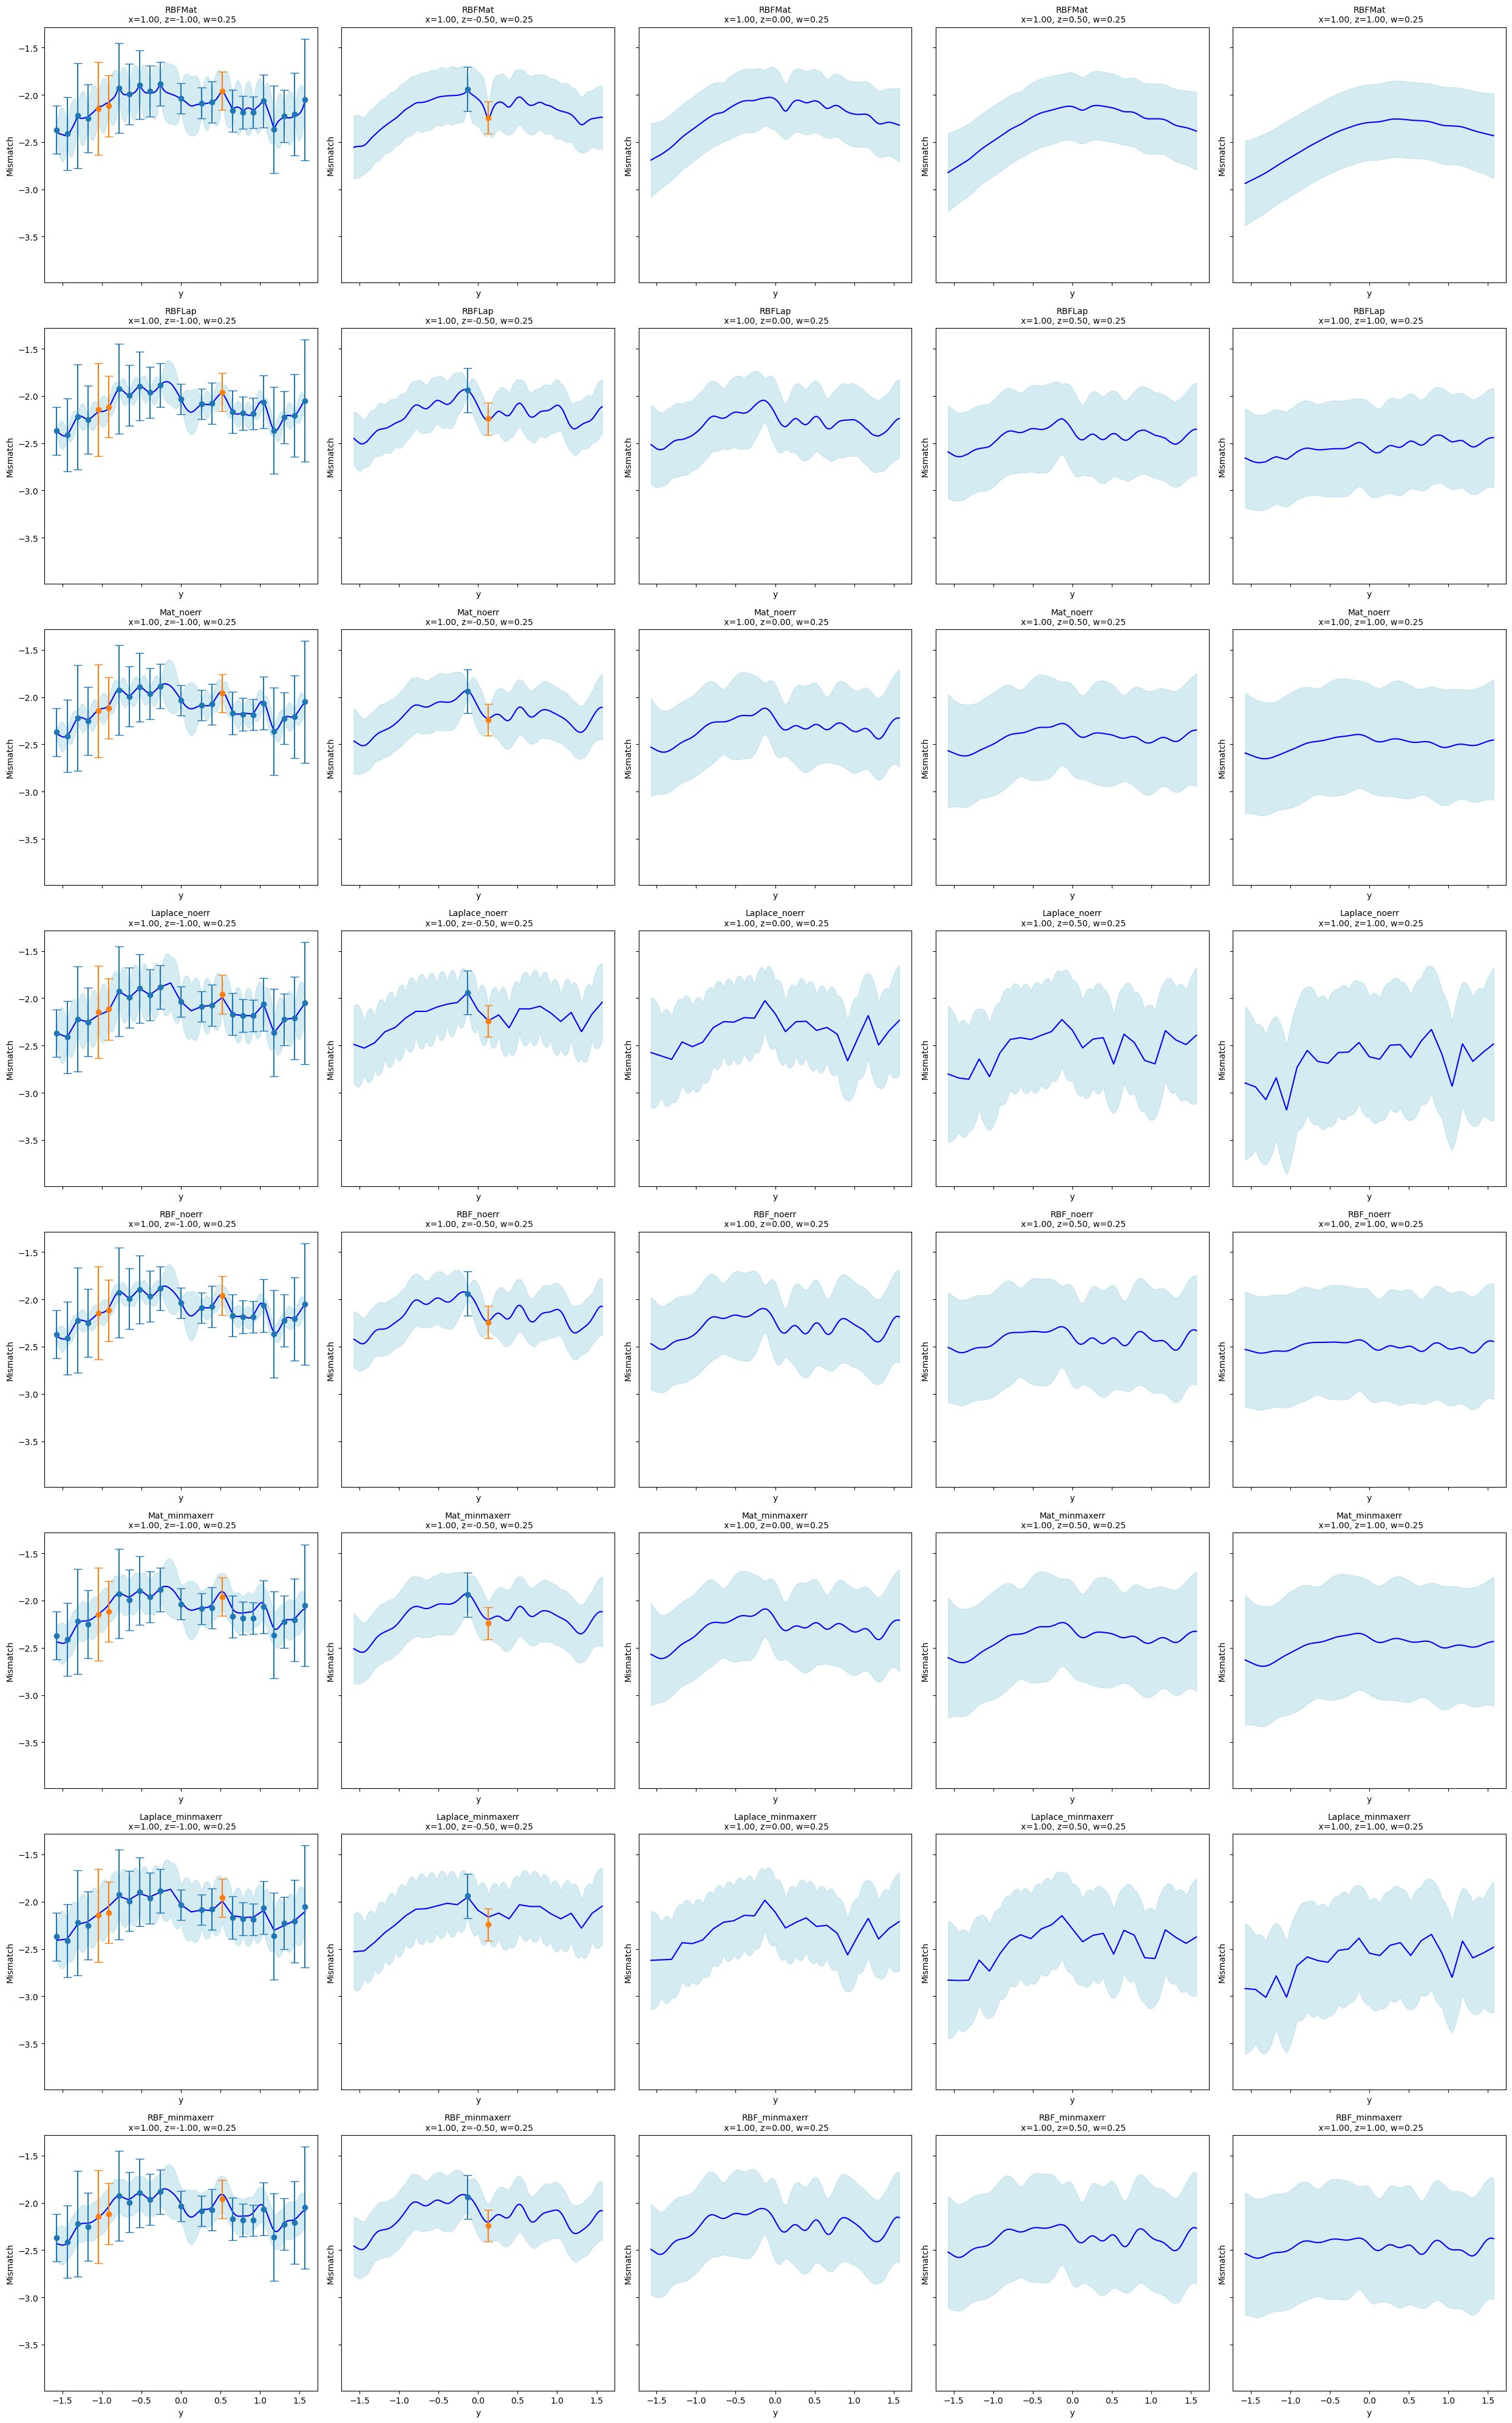

In [11]:
# Data filtering: Only use indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]
X1_train = X[train1indices]
X1_test = X[test1indices]
D1_train = D[train1indices]
D1_test = D[test1indices]
E1_train = E[train1indices]
E1_test = E[test1indices]

# Extract columns
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Define the input domains
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
ypoints = np.linspace(-np.pi/2, np.pi/2, 25)
wpoints = np.linspace(0.25, 1, 4)

i = 9  # index for xpoint
xpoint = xpoints[i]
j = 0  # index for wpoint
wpoint = wpoints[j]


# Plotting setup
num_kernels = len(kernel_names)
fig, axes = plt.subplots(nrows=num_kernels, ncols=5, figsize=(25, 5 * num_kernels), sharex=True, sharey=True)

for row, kernel_name in enumerate(tqdm(kernel_names, desc="Processing kernels")):
    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]

        # Predict over y-axis, keeping x, z, w fixed
        Xpred = np.column_stack((
            np.full_like(ydomain, xpoint),
            ydomain,
            np.full_like(ydomain, zpoint),
            np.full_like(ydomain, wpoint)
        ))

        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(ydomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Nearby training/test points
        indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest = np.isclose(x1test, xpoint, atol=0.05) & np.isclose(z1test, zpoint, atol=0.05)

        ax.errorbar(y1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain], fmt='o', color='#1f77b4', capsize=5)
        ax.errorbar(y1test[indtest],  D1_test[indtest],  yerr=E1_test[indtest],  fmt='o', color='#ff7f0e', capsize=5)

        ax.set_title(f"{kernel_name}\n x={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("y")
        ax.set_ylabel("Mismatch")

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\final_gps_xcuts", dpi=72, bbox_inches='tight')
plt.show()


Kernel used: 1.53**2 * RBF(length_scale=[1, 1.51, 1.38, 1.36]) + 0.455**2 * Matern(length_scale=[0.0996, 0.0582, 0.414, 2.31], nu=0.75)


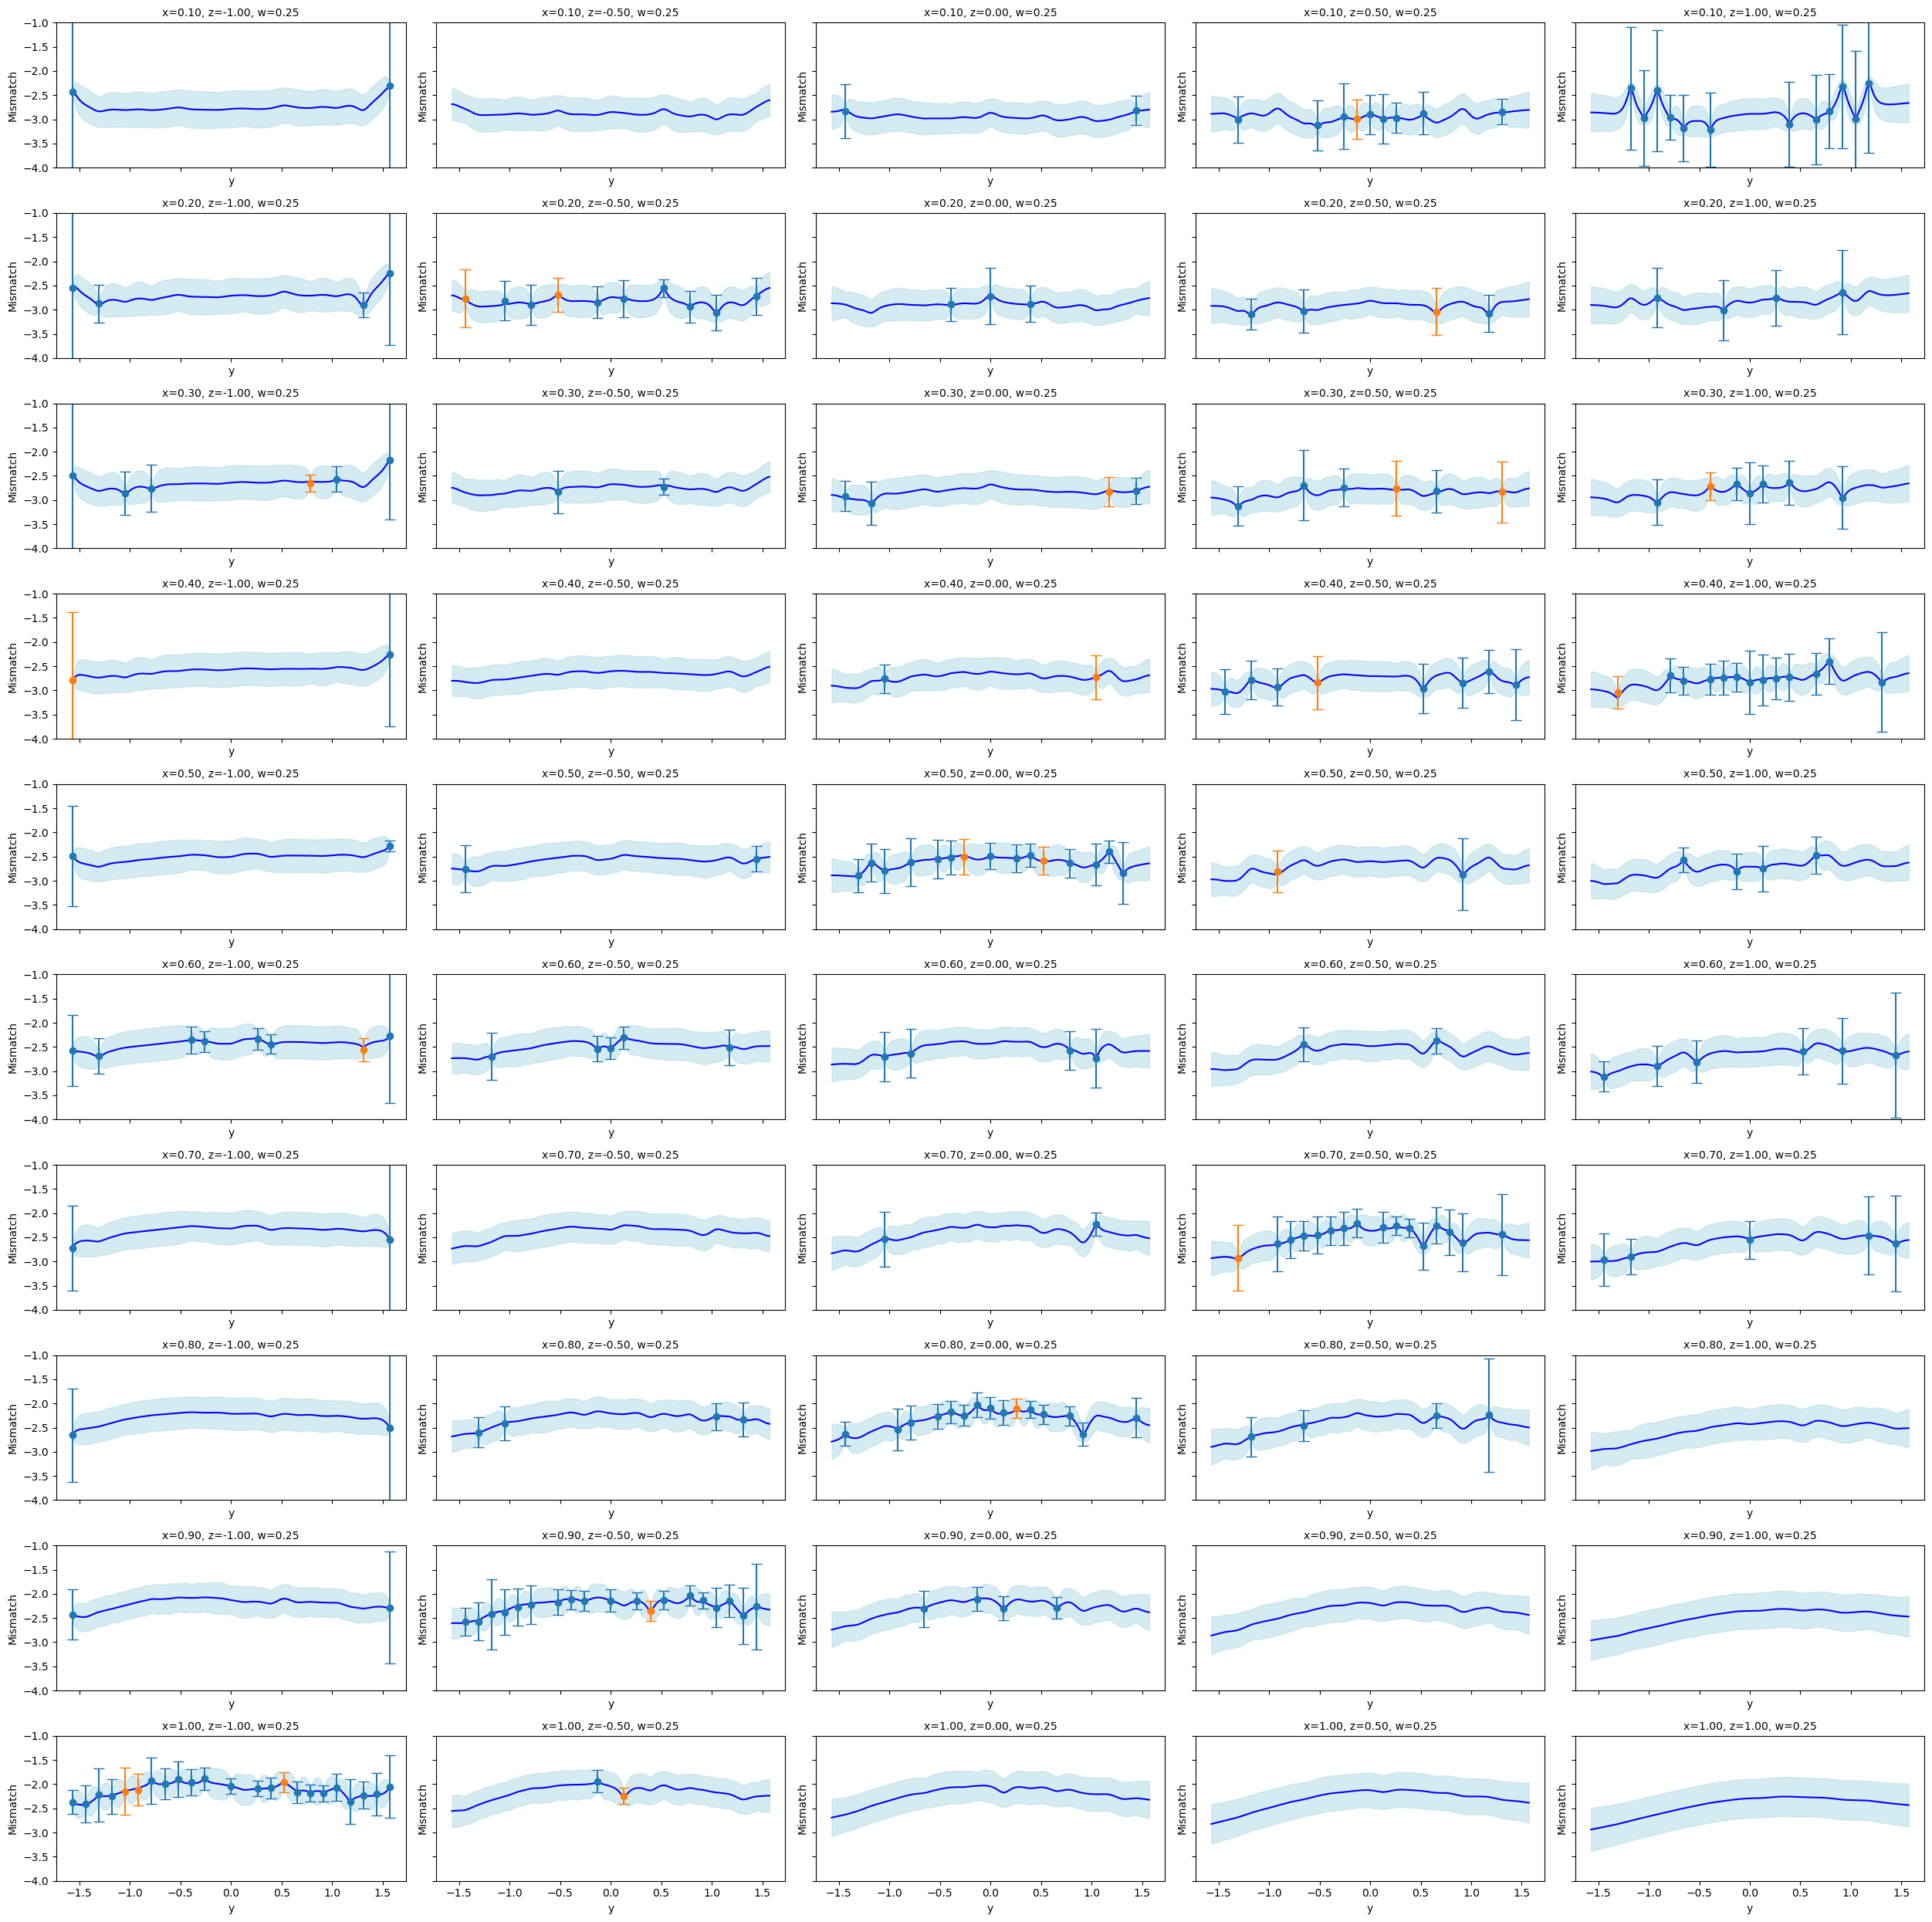

In [13]:
# Filter dataset to indices <= 249
train1indices = indices_trainval[indices_trainval <= 249]
test1indices = indices_test[indices_test <= 249]

X1_train, X1_test = X[train1indices], X[test1indices]
D1_train, D1_test = D[train1indices], D[test1indices]
E1_train, E1_test = E[train1indices], E[test1indices]

# Extract relevant coordinates
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Define domains
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)
zpoints = np.linspace(-1, 1, 5)
xpoints = np.linspace(0.1, 1, 10)
xpoints_plot = np.array([xpoints[0], xpoints[2], xpoints[4], xpoints[6], xpoints[9]])
wpoints = np.linspace(0.25, 1, 4)

# Choose w value
wpoint = wpoints[0]

# Load RBFMat model
model_path = os.path.join(base_dir, 'GPR_RBFMat.joblib')
gpr_loaded = load(model_path)
print("Kernel used:", gpr_loaded.kernel_)

# Set up figure
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(25, 25), sharex=True, sharey=True)

# Generate subplots
for row, xpoint in enumerate(xpoints):
    for col, zpoint in enumerate(zpoints):
        ax = axes[row, col]

        # Build prediction input
        Xpred = np.column_stack((
            np.full(ydomain.shape, xpoint),
            ydomain,
            np.full(ydomain.shape, zpoint),
            np.full(ydomain.shape, wpoint)
        ))

        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)

        # Plot prediction
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(ydomain, pred_mean - 2 * pred_std, pred_mean + 2 * pred_std, color='lightblue', alpha=0.5)

        # Filter data near x/z cut
        indtrain = np.isclose(x1train, xpoint, atol=0.05) & np.isclose(z1train, zpoint, atol=0.05)
        indtest  = np.isclose(x1test,  xpoint, atol=0.05) & np.isclose(z1test,  zpoint, atol=0.05)

        # Overlay points
        ax.errorbar(y1train[indtrain], D1_train[indtrain], yerr=E1_train[indtrain],
                    fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest], D1_test[indtest], yerr=E1_test[indtest],
                    fmt='o', capsize=5, color='#ff7f0e')

        ax.set_ylim((-4, -1))
        ax.set_title(f"x={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}", fontsize=10)
        ax.set_xlabel("y", fontsize=10)
        ax.set_ylabel("Mismatch", fontsize=10)

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\gps_rbfmatern_xcuts", dpi=72, bbox_inches='tight')
plt.show()


DataSet 2: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


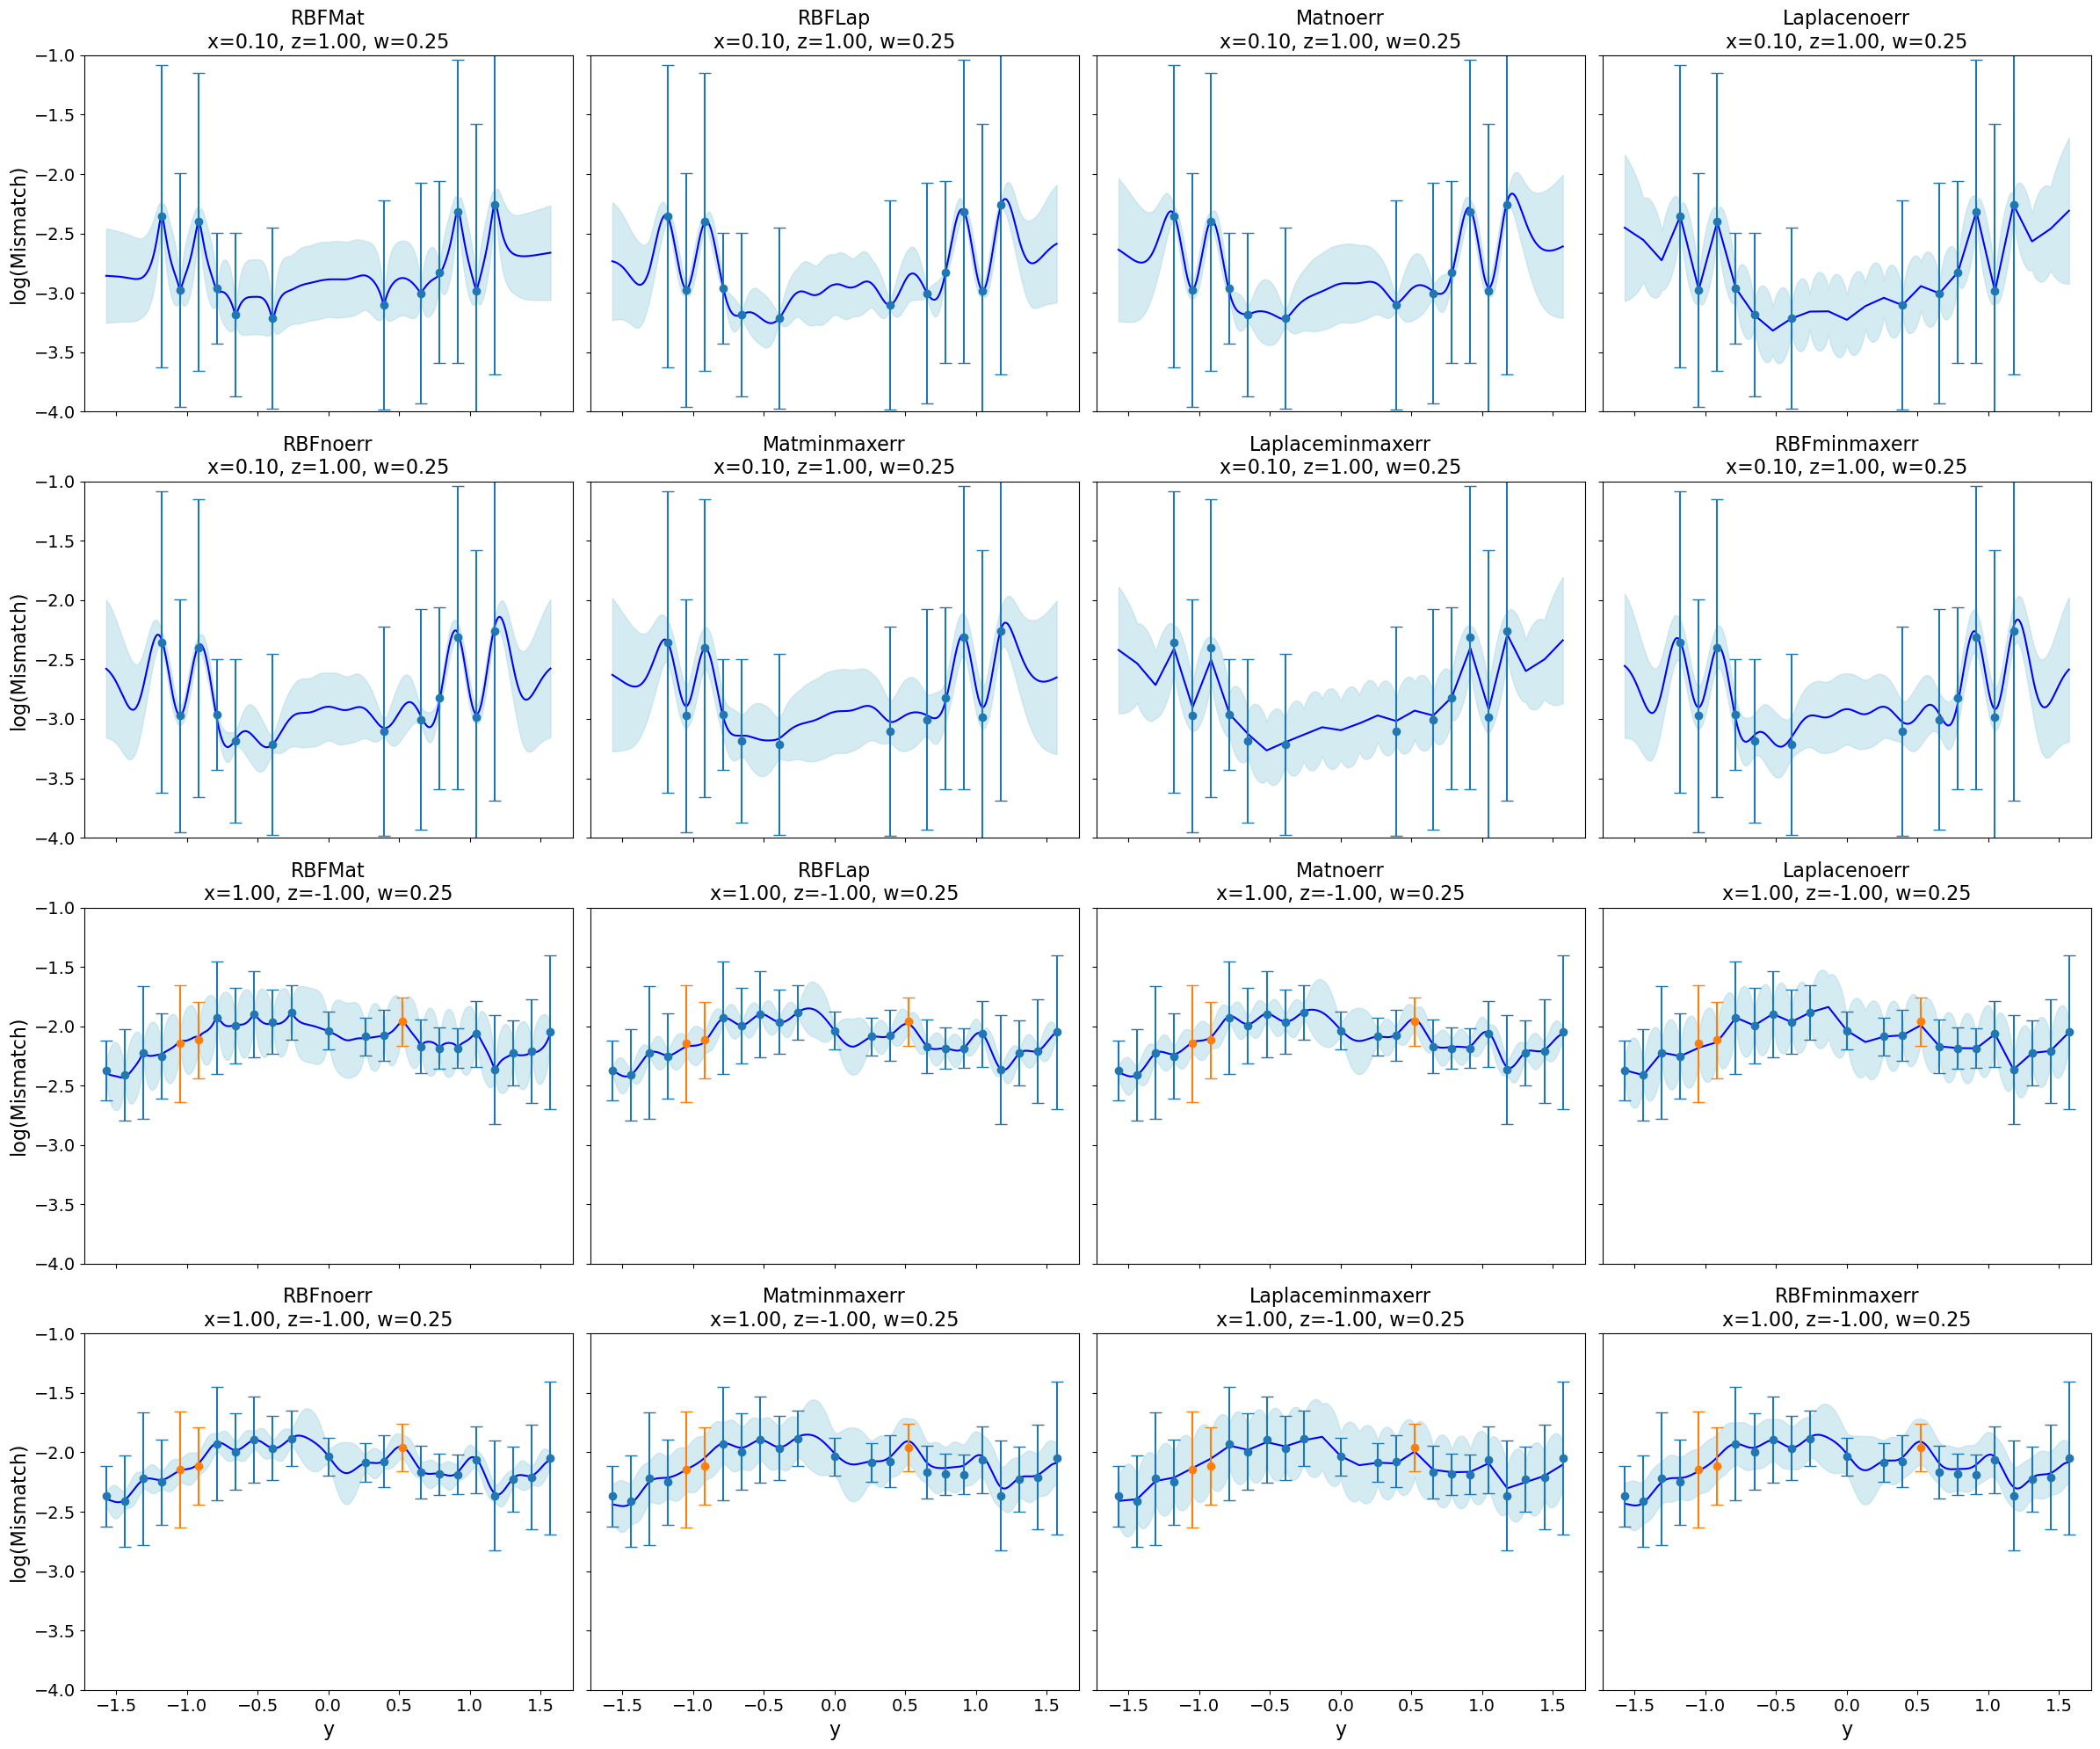

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm

base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'

# Filter dataset
train1indices = indices_trainval[indices_trainval <= 249]
test1indices  = indices_test[indices_test <= 249]

X1_train, X1_test = X[train1indices], X[test1indices]
D1_train, D1_test = D[train1indices], D[test1indices]
E1_train, E1_test = E[train1indices], E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

# Domain for predictions
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)

# The (x,z,w) combos you want to examine:
xpoints_plot = np.array([0.1, 1.0])   # 2 sets
zpoints_plot = np.array([1.0, -1.0])
wpoints_plot = np.array([0.25, 0.25])  # same w in this example

# Suppose we have 8 kernels:
kernel_names = [
    "RBFMat", "RBFLap", "Mat_noerr", "Laplace_noerr",
    "RBF_noerr", "Mat_minmaxerr", "Laplace_minmaxerr", "RBF_minmaxerr"
]

kernel_names_toplot = [
    "RBFMat", "RBFLap", "Matnoerr", "Laplacenoerr",
    "RBFnoerr", "Matminmaxerr", "Laplaceminmaxerr", "RBFminmaxerr"]
num_kernels = len(kernel_names)  # = 8

# We want 2 sets of points × 8 kernels = 16 subplots in a 4×4 grid.
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 20),
                         sharex=True, sharey=True)

for i in range(len(xpoints_plot)):
    xpoint = xpoints_plot[i]
    zpoint = zpoints_plot[i]
    wpoint = wpoints_plot[i]
    
    # row_offset ensures that each data‐point set occupies 2 rows
    row_offset = i * 2
    
    # Loop over each kernel
    for k, kernel_name in enumerate(tqdm(kernel_names, desc=f"DataSet {i+1}")):
        # row, col for the subplot:
        row = row_offset + (k // 4)   # integer division
        col = k % 4
        #row =i   # integer division
        #col = k % 8

        ax = axes[row, col]
        
        # Load the GPR model
        model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
        gpr_loaded = load(model_path)
        
        # Build prediction input: we keep (x,z,w) fixed, vary y
        Xpred = np.column_stack((
            np.full(ydomain.shape, xpoint),
            ydomain,
            np.full(ydomain.shape, zpoint),
            np.full(ydomain.shape, wpoint)
        ))
        
        # Predict
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
        
        # Plot GP predictions
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(
            ydomain,
            pred_mean - 2*pred_std,
            pred_mean + 2*pred_std,
            color='lightblue',
            alpha=0.5
        )
        
        # Filter training/test data near (x,z) = (xpoint,zpoint)
        # (within ±0.05, for instance)
        indtrain = (
            np.isclose(x1train, xpoint, atol=0.05) &
            np.isclose(z1train, zpoint, atol=0.05)
        )
        indtest = (
            np.isclose(x1test, xpoint, atol=0.05) &
            np.isclose(z1test, zpoint, atol=0.05)
        )
        
        # Overlay points
        ax.errorbar(y1train[indtrain], D1_train[indtrain],
                    yerr=E1_train[indtrain], fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest], D1_test[indtest],
                    yerr=E1_test[indtest], fmt='o', capsize=5, color='#ff7f0e')
        
        ax.set_ylim((-4, -1))
        ax.set_title(f"{kernel_names_toplot[k]}\nx={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}",
                    fontsize=16)
        ax.tick_params(axis='both', labelsize=14)

        if row == 3:
            ax.set_xlabel("y", fontsize=16)
        if col == 0:
            ax.set_ylabel("log(Mismatch)", fontsize=16)

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\gps_crosscuts_bestmodels", dpi=72, bbox_inches='tight')
plt.show()

(250,)
(1000,)


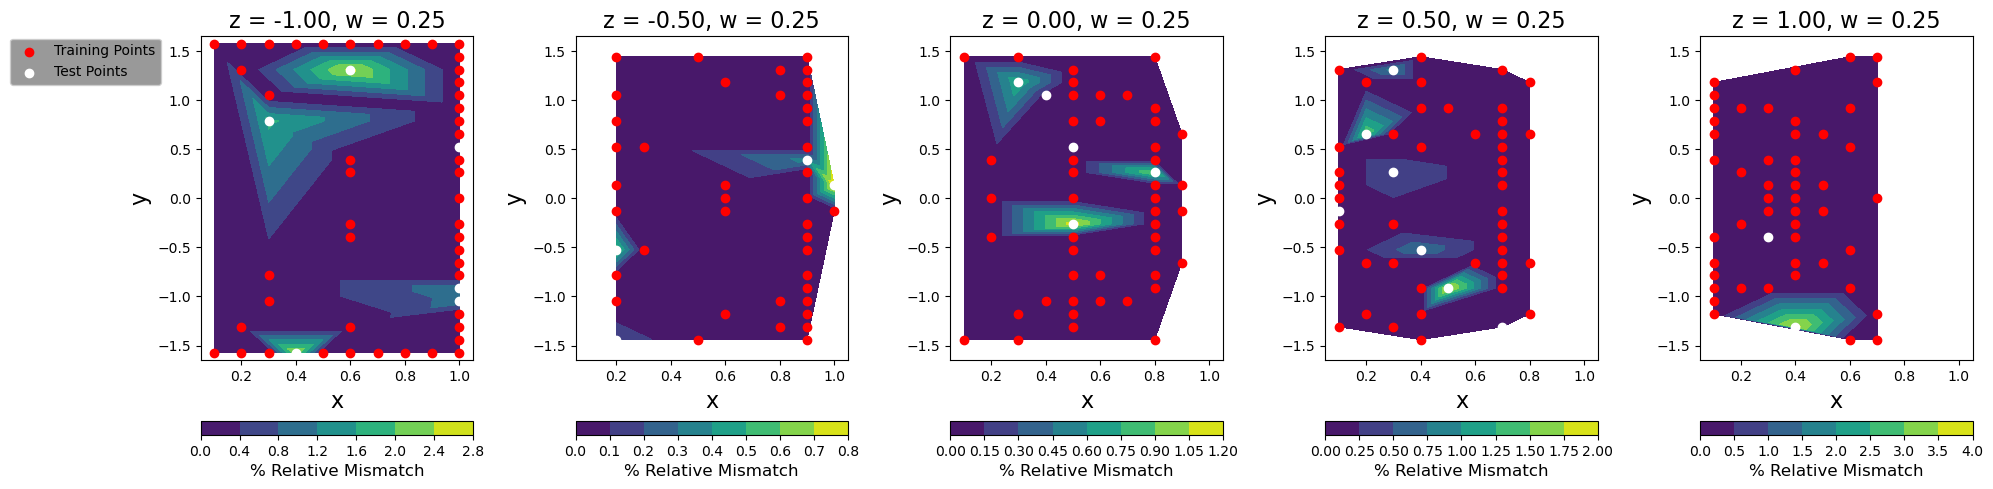

In [ ]:
### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)


train1indices = indices_trainval[indices_trainval <= 249]
test1indices  = indices_test[indices_test <= 249]

X1_train, X1_test = X[train1indices], X[test1indices]
D1_train, D1_test = D[train1indices], D[test1indices]
E1_train, E1_test = E[train1indices], E[test1indices]

# Extract columns (assuming X has columns: x, y, z, w)
x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]


kernel_name = "RBFMat"
# Assuming indices, indicestrain, and indicestest have been defined beforehand, for example:
# indices = np.arange(len(xm1))

zpoints = np.linspace(-1, 1, 5)  # 5 evenly spaced z-points
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

zpoint = 0
inds = np.isclose(zm1, zpoint)
print(inds.shape)
print(indices.shape)
indices_m1 = indices[:250]

for j, zpoint in enumerate(zpoints):
    # Find those data points at the current zpoint
    inds = np.isclose(zm1, zpoint)
    
    # Get the indices of points (if you already have "indices" as np.arange(...))
    indices_z = indices_m1[inds]
    
    # Split the indices into training and test for this z cut
    indicestrain_z = np.intersect1d(indices_z, train1indices)
    indicestest_z = np.intersect1d(indices_z, test1indices)

    model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
    gpr_loaded = load(model_path)

    gprmean, gprstd = gpr_loaded.predict(X1, return_std=True)
    
    # Compute the mismatch (absolute difference)
    d_z = dm1[inds]
    gprmean_z = gprmean[inds]
    mismatch_z = np.abs(gprmean_z - d_z)/np.abs(d_z)*100
    
    # Extract corresponding x and y for these points
    xm1_z = xm1[inds]
    ym1_z = ym1[inds]
    
    # Plot the contour on the current axis
    contour = axes[j].tricontourf(xm1_z, ym1_z, mismatch_z, cmap='viridis')
    
    # Plot training and test points
    axes[j].scatter(xm1[indicestrain_z], ym1[indicestrain_z],
                    color='red', marker='o', label='Training Points')
    axes[j].scatter(xm1[indicestest_z], ym1[indicestest_z],
                    color='white', marker='o', label='Test Points')
    
    # Add the colorbar for this axis
    cbar = fig.colorbar(contour, ax=axes[j], orientation='horizontal', 
                        fraction=0.05, pad=0.15)
    cbar.set_label('% Relative Mismatch', fontsize=12)
    
    # Add legend with grey background (attached to the axis)
    if (j==0):
        leg = axes[j].legend(loc=(-0.7, 0.85))
        leg.get_frame().set_facecolor('grey')
    
    # Set labels and title for this subplot
    axes[j].set_xlabel("x", fontsize=16)
    axes[j].set_ylabel("y", fontsize=16)
    axes[j].set_title("z = %0.2f, w = 0.25" % (zpoint),fontsize=16)
    axes[j].set_xlim((0.05, 1.05))
    axes[j].set_ylim((-1.65, 1.65))

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\Relative_mismatch", dpi=72, bbox_inches='tight')
plt.show()

DataSet 3: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


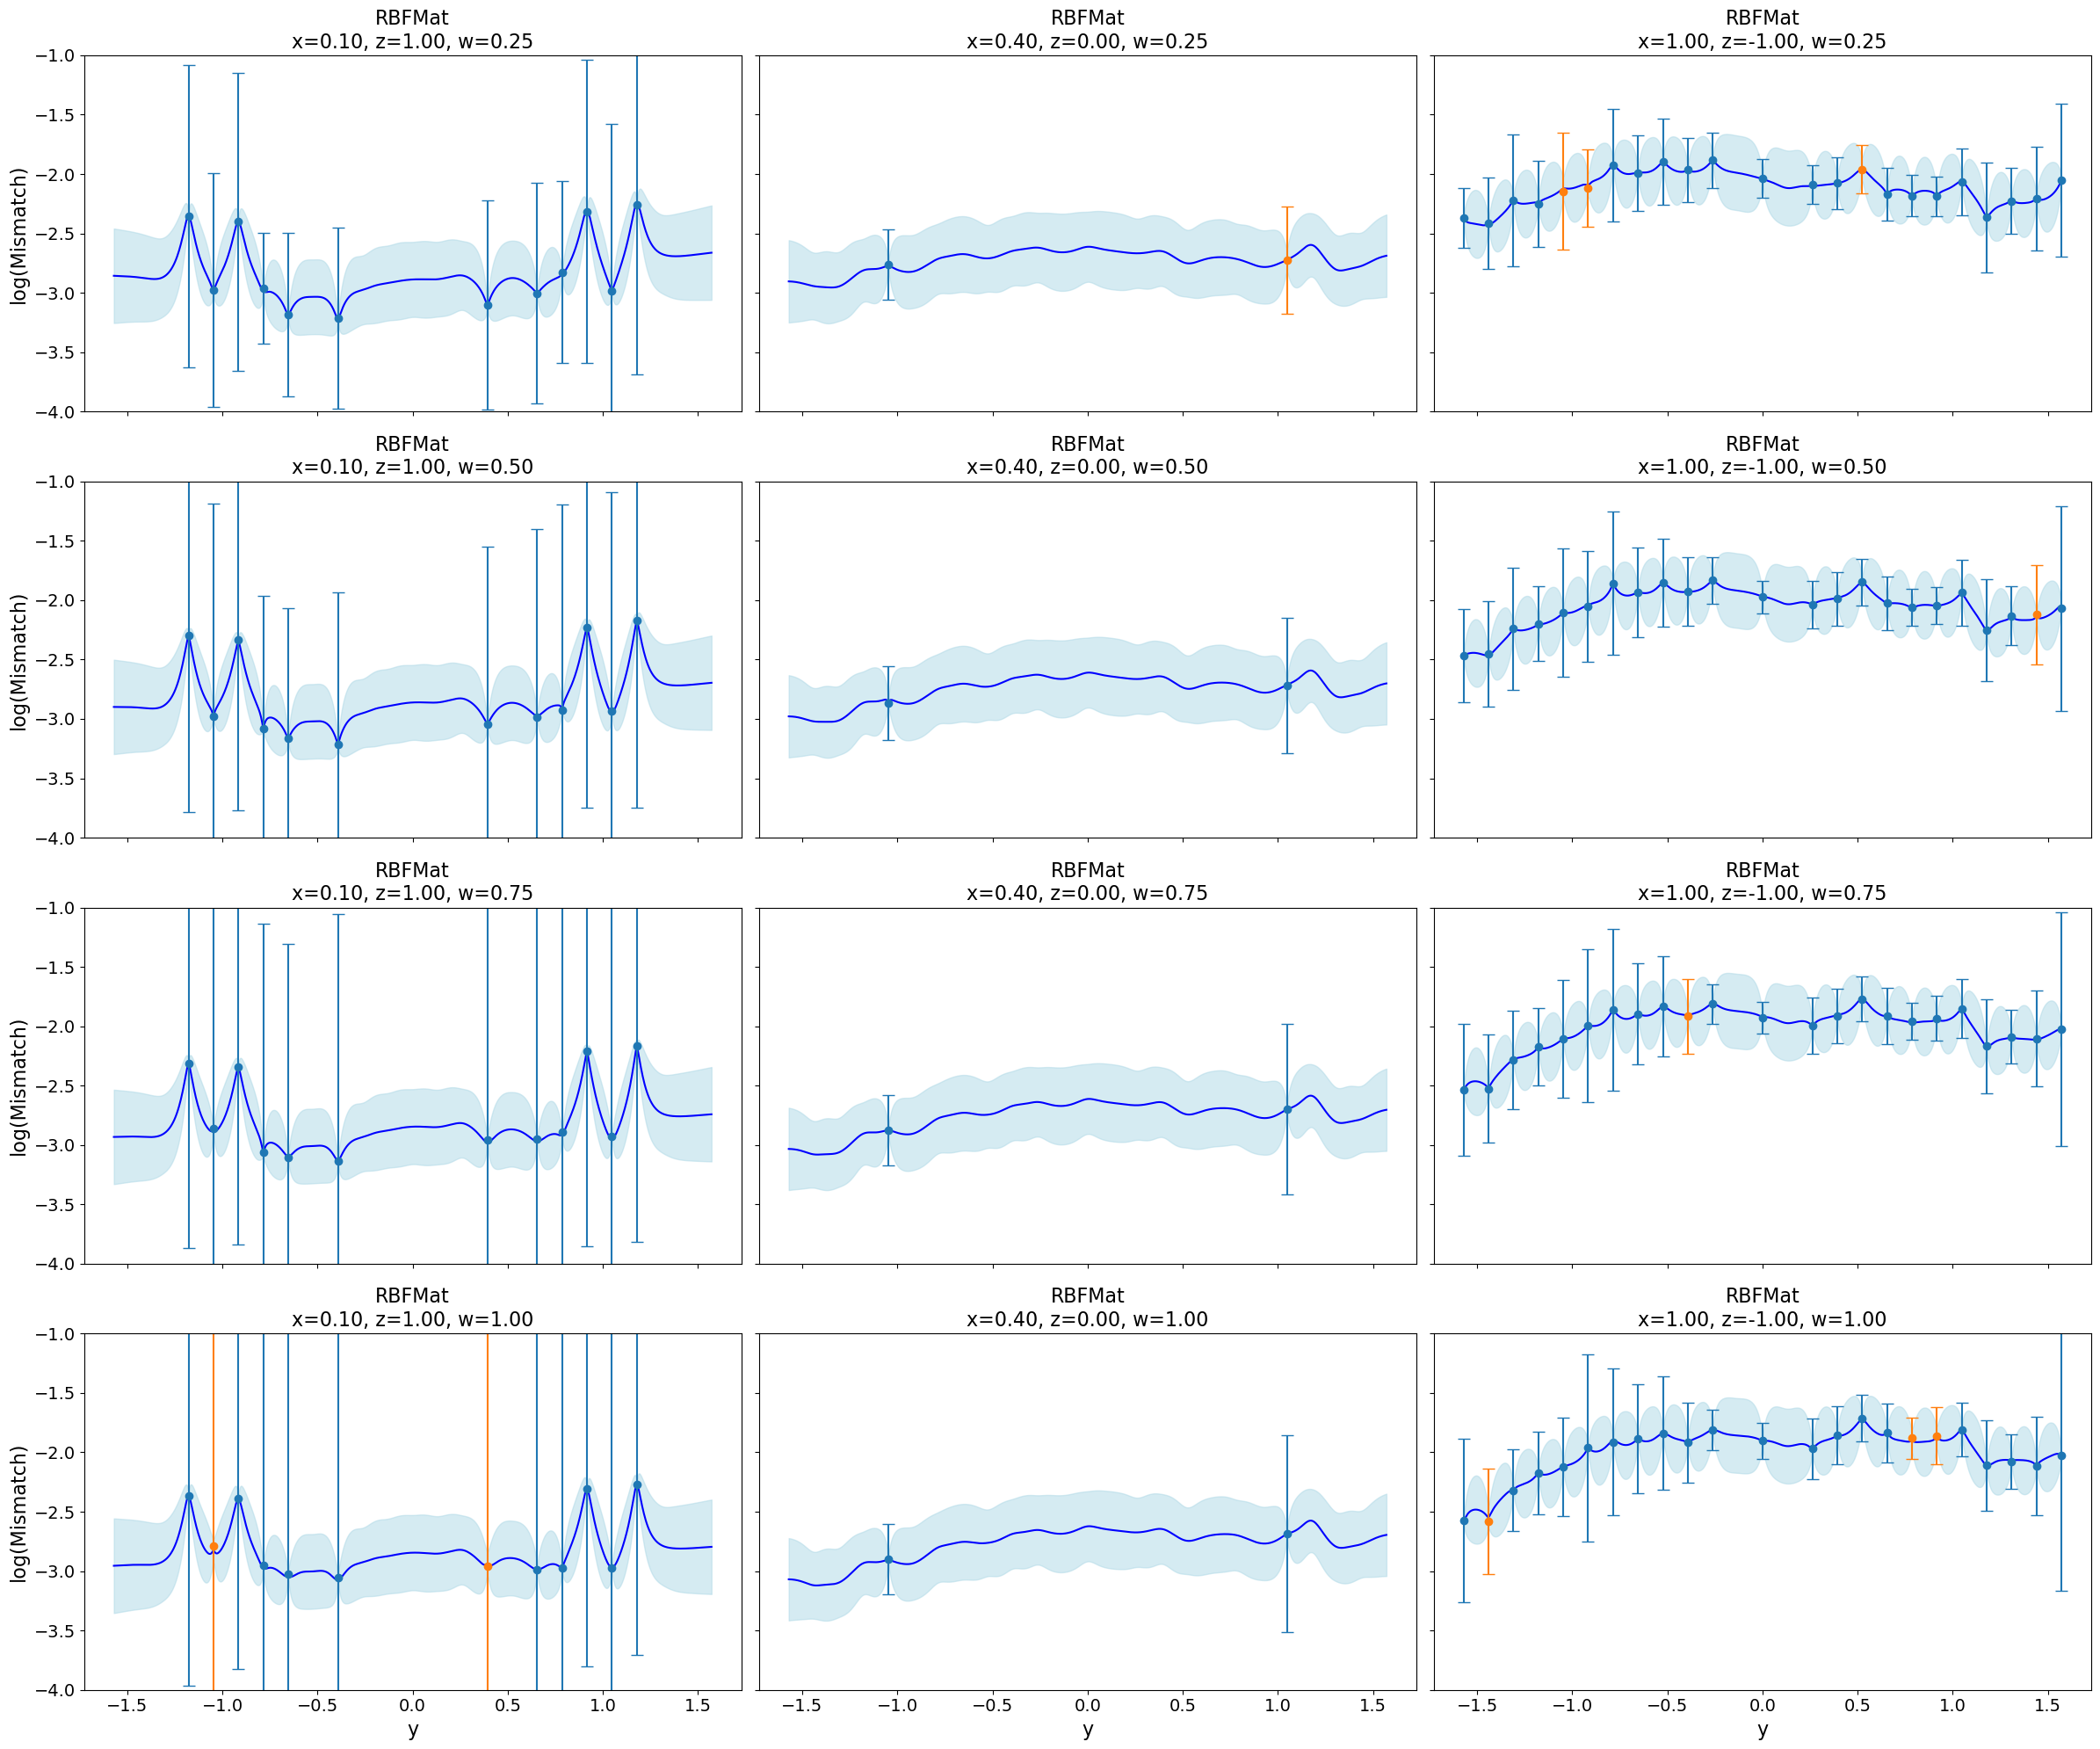

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
from tqdm import tqdm

base_dir = r'C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final_gps'

# Domain for predictions
ydomain = np.linspace(-np.pi/2, np.pi/2, 1000)

# The (x,z,w) combos you want to examine:
xpoints_plot = np.array([0.1,0.4, 1.0])   # 2 sets
zpoints_plot = np.array([1.0,0, -1.0])
wpoints_plot = np.array([0.25,0.5,0.75,1])  # same w in this example


kernel_name = "RBFMat"
kernel_names_toplot = "RBFMat"
num_kernels = len(kernel_names) 

# We want 2 sets of points × 8 kernels = 16 subplots in a 4×4 grid.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24, 20),
                         sharex=True, sharey=True)



for k, wpoint in enumerate(tqdm(wpoints_plot, desc=f"DataSet {i+1}")):
    row = k
    # Compute block start and end
    start_idx = 250 * k
    end_idx = 250 * (k + 1)

    # Apply index-based filtering before proximity filtering
    train1indices = indices_trainval[(indices_trainval >= start_idx) & (indices_trainval < end_idx)]
    test1indices  = indices_test[(indices_test >= start_idx) & (indices_test < end_idx)]


    X1_train, X1_test = X[train1indices], X[test1indices]
    D1_train, D1_test = D[train1indices], D[test1indices]
    E1_train, E1_test = E[train1indices], E[test1indices]

    # Extract columns (assuming X has columns: x, y, z, w)
    x1train, y1train, z1train = X1_train[:, 0], X1_train[:, 1], X1_train[:, 2]
    x1test,  y1test,  z1test  = X1_test[:, 0],  X1_test[:, 1],  X1_test[:, 2]

    for i in range(len(xpoints_plot)):
        xpoint = xpoints_plot[i]
        zpoint = zpoints_plot[i]
        # row_offset ensures that each data‐point set occupies 2 rows
        col = i

        ax = axes[row, col]
        
        # Load the GPR model
        model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
        gpr_loaded = load(model_path)
        
        # Build prediction input: we keep (x,z,w) fixed, vary y
        Xpred = np.column_stack((
            np.full(ydomain.shape, xpoint),ydomain,
            np.full(ydomain.shape, zpoint),
            np.full(ydomain.shape, wpoint)
        ))
        
        # Predict
        pred_mean, pred_std = gpr_loaded.predict(Xpred, return_std=True)
        
        # Plot GP predictions
        ax.plot(ydomain, pred_mean, color='blue')
        ax.fill_between(
            ydomain,
            pred_mean - 2*pred_std,
            pred_mean + 2*pred_std,
            color='lightblue',
            alpha=0.5
        )
        
        indtrain = (
            np.isclose(x1train, xpoint, atol=0.05) &
            np.isclose(z1train, zpoint, atol=0.05)
        )
        indtest = (
            np.isclose(x1test, xpoint, atol=0.05) &
            np.isclose(z1test, zpoint, atol=0.05)
        )
        
        # Overlay points
        ax.errorbar(y1train[indtrain], D1_train[indtrain],
                    yerr=E1_train[indtrain], fmt='o', capsize=5, color='#1f77b4')
        ax.errorbar(y1test[indtest], D1_test[indtest],
                    yerr=E1_test[indtest], fmt='o', capsize=5, color='#ff7f0e')
        
        ax.set_ylim((-4, -1))
        ax.set_title(f"{kernel_names_toplot}\nx={xpoint:.2f}, z={zpoint:.2f}, w={wpoint:.2f}",
                    fontsize=16)
        ax.tick_params(axis='both', labelsize=14)

        if row == 3:
            ax.set_xlabel("y", fontsize=16)
        if col == 0:
            ax.set_ylabel("log(Mismatch)", fontsize=16)

plt.tight_layout()
#plt.savefig(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\latex\LatexPlots\final_gps_plots\change_over_masses", dpi=72, bbox_inches='tight')
plt.show()

In [35]:
for kernel_name in kernel_names:
  model_path = os.path.join(base_dir, f'GPR_{kernel_name}.joblib')
  gpr_loaded = load(model_path)
  print(gpr_loaded.kernel_)

1.53**2 * RBF(length_scale=[1, 1.51, 1.38, 1.36]) + 0.455**2 * Matern(length_scale=[0.0996, 0.0582, 0.414, 2.31], nu=0.75)
0.595**2 * RBF(length_scale=[0.1, 0.1, 1.18, 2.91]) + 0.54**2 * PairwiseKernel(gamma=0.9641296786288961, metric=laplacian)
0.962**2 * Matern(length_scale=[0.227, 0.2, 1.15, 2.85], nu=1.75) + WhiteKernel(noise_level=0.00637)
2.69**2 * PairwiseKernel(gamma=0.35784796960372983, metric=laplacian) + WhiteKernel(noise_level=1e-06)
0.853**2 * RBF(length_scale=[0.112, 0.112, 0.958, 1.6]) + WhiteKernel(noise_level=0.00728)
1.07**2 * Matern(length_scale=[0.27, 0.22, 1.34, 4.73], nu=1.75) + WhiteKernel(noise_level=0.0439)
2.57**2 * PairwiseKernel(gamma=0.28424121407081104, metric=laplacian) + WhiteKernel(noise_level=0.0439)
0.906**2 * RBF(length_scale=[0.12, 0.115, 1.19, 2.52]) + WhiteKernel(noise_level=0.0439)
